Question-1

In [9]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kl_div
from scipy.optimize import minimize

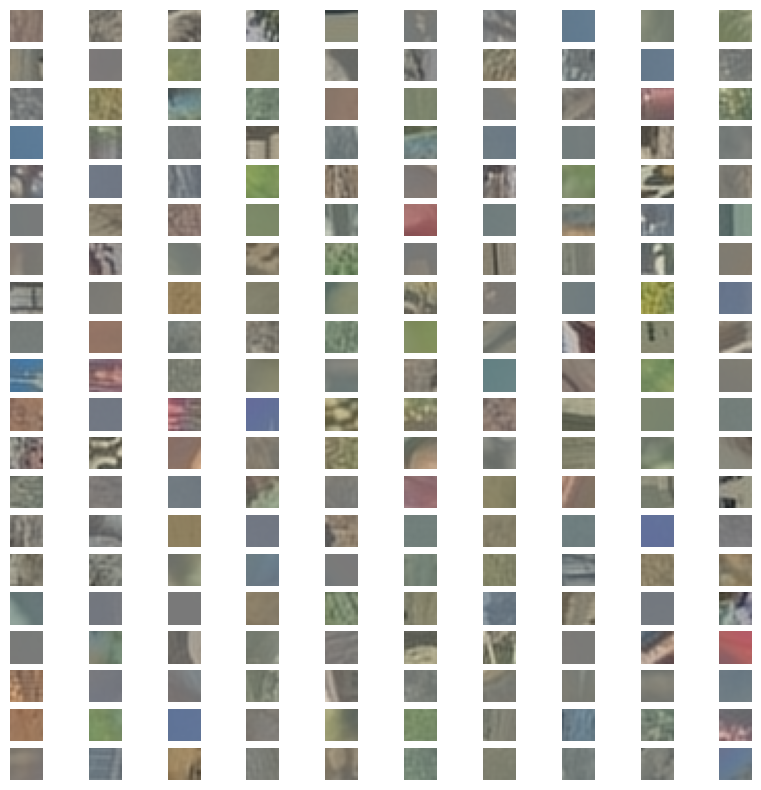

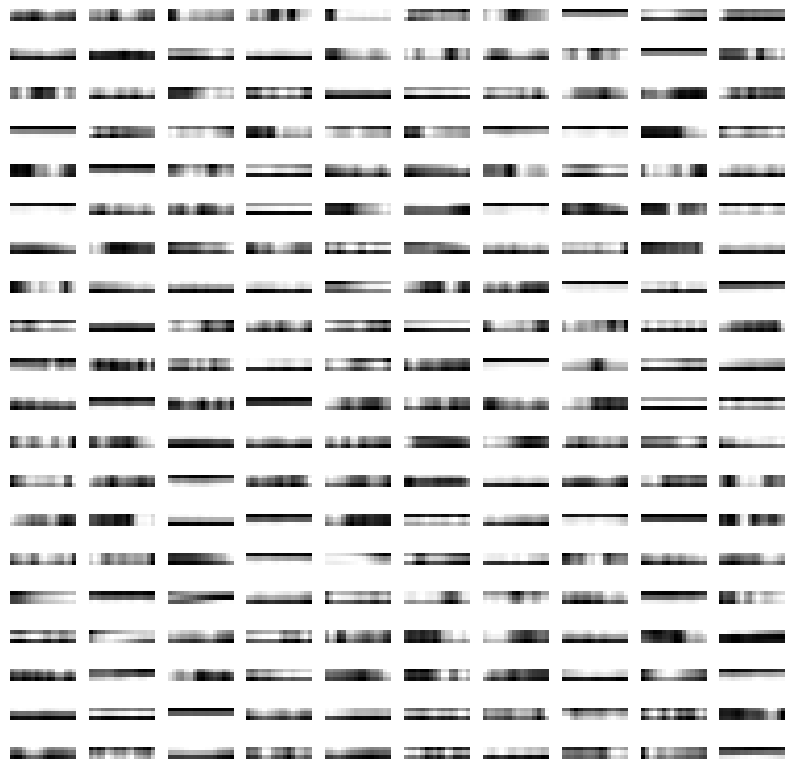

In [21]:
# a) Preprocess the data

# Load data
def load_data(filename):
    with h5py.File(filename, 'r') as hf:
        data = np.array(hf['data'])
    return data

# Convert to grayscale
def rgb2gray(data):
    return 0.2126 * data[:, :, :, 0] + 0.7152 * data[:, :, :, 1] + 0.0722 * data[:, :, :, 2]

# Normalize data
def normalize_data(data):
    min_pixel_intensity = np.min(data)
    max_pixel_intensity = np.max(data)
    normalized_data = (data - min_pixel_intensity) / (max_pixel_intensity - min_pixel_intensity)
    return normalized_data

# Display 200 random sample patches
def display_patches(data, normalized_data, num_patches=200):
    indices = np.random.choice(data.shape[0], num_patches, replace=False)
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(indices):
        plt.subplot(20, 10, i + 1)
        plt.axis('off')
        plt.imshow(np.transpose(data[idx], (1, 2, 0)))
    plt.show()

    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(indices):
        plt.subplot(20, 10, i + 1)
        plt.axis('off')
        plt.imshow(normalized_data[idx], cmap='gray')
    plt.show()

data = load_data('data1.h5')
normalized_color_data = normalize_data(data)
gray_data = rgb2gray(normalized_color_data)
normalized_gray_data = normalize_data(gray_data)
display_patches(normalized_color_data, normalized_gray_data)

Randomly selected patches and their Post-grayscale conversion and normalization could be observed above.

In [22]:
# Question 1-b
import numpy as np

# Define the activation function and its derivative
def sigmoid(x, deriv=False):
    if deriv:
        return x * (1 - x)
    return 1 / (1 + np.exp(-x))

# Initialize the weights and biases
def initialize_weights(Lin, Lhid, Lout):
    wo1 = np.sqrt(6 / (Lin + Lhid))
    W1 = np.random.uniform(-wo1, wo1, (Lhid, Lin))
    wo2 = np.sqrt(6 / (Lhid + Lout))
    W2 = np.random.uniform(-wo2, wo2, (Lout, Lhid))
    b1 = np.random.uniform(-wo1, wo1, (Lhid, 1))
    b2 = np.random.uniform(-wo2, wo2, (Lout, 1))
    return W1, W2, b1, b2

# Define the cost function and its gradient
def aeCost(We, data, params):
    Lin, Lhid, Lout = params['Lin'], params['Lhid'], params['Lout']
    lambda_, beta, rho = params['lambda'], params['beta'], params['rho']
    N = data.shape[1]

    # Reshape We into W1, W2, b1, b2
    W1 = We[:Lhid * Lin].reshape((Lhid, Lin))
    W2 = We[Lhid * Lin:Lhid * (Lin + Lout)].reshape((Lout, Lhid))
    b1 = We[Lhid * (Lin + Lout):Lhid * (Lin + Lout) + Lhid].reshape((Lhid, 1))
    b2 = We[Lhid * (Lin + Lout) + Lhid:].reshape((Lout, 1))

    # Forward pass
    a1 = data.T
    z2 = W1 @ a1 + b1
    a2 = sigmoid(z2)
    z3 = W2 @ a2 + b2
    a3 = sigmoid(z3)

    # Compute cost
    J_err = 1 / (2 * N) * np.sum((a3 - a1)**2)
    J_reg = lambda_ / 2 * (np.sum(W1**2) + np.sum(W2**2))
    rho_hat = np.mean(a2, axis=1).reshape(-1, 1)
    J_sparse = beta * np.sum(rho * np.log(rho / rho_hat) + (1 - rho) * np.log((1 - rho) / (1 - rho_hat)))
    J = J_err + J_reg + J_sparse

    # Backward pass
    delta3 = -(a1 - a3) * a3 * (1 - a3)
    delta2 = (W2.T @ delta3 + beta * (-rho / rho_hat + (1 - rho) / (1 - rho_hat))) * a2 * (1 - a2)

    # Compute gradients
    W1_grad = delta2 @ a1.T / N + lambda_ * W1
    W2_grad = delta3 @ a2.T / N + lambda_ * W2
    b1_grad = np.mean(delta2, axis=1, keepdims=True)
    b2_grad = np.mean(delta3, axis=1, keepdims=True)
    Jgrad = np.concatenate((W1_grad.ravel(), W2_grad.ravel(), b1_grad.ravel(), b2_grad.ravel()))

    return J, Jgrad

params = {
    'Lin': 48,
    'Lhid': 64,
    'Lout': 48,
    'lambda': 0.0005,
    'beta': 3,
    'rho': 0.1
}

# Initialize weights and biases
W1_init = np.random.randn(params['Lhid'], params['Lin']) * np.sqrt(2 / (params['Lin'] + params['Lhid']))
W2_init = np.random.randn(params['Lout'], params['Lhid']) * np.sqrt(2 / (params['Lhid'] + params['Lout']))
b1_init = np.zeros((params['Lhid'], 1))
b2_init = np.zeros((params['Lout'], 1))

# Flatten and concatenate all weights and biases
We_init = np.concatenate([W1_init.flatten(), W2_init.flatten(), b1_init.flatten(), b2_init.flatten()])


# Minimize cost function
result = minimize(aeCost, We_init, args=(reshaped_data, params), jac=True, method='L-BFGS-B')

# Extract optimized weights
We_opt = result.x
W1_opt = We_opt[:params['Lhid'] * params['Lin']].reshape((params['Lhid'], params['Lin']))

print('Optimized weights: ', W1_opt)




Optimized weights:  [[ 0.13426937 -0.08488326 -0.13708906 ...  0.05010585  0.07139727
  -0.02195106]
 [ 0.85391006 -0.03024933 -0.43768251 ... -0.58950378 -0.24832815
  -0.21815281]
 [ 0.25301962  0.32812943  0.56328759 ... -0.10544899  0.00391377
  -0.28121734]
 ...
 [-0.53301137 -0.43721221 -0.59015328 ... -0.37658772  0.38462974
   0.91651512]
 [-0.28207942 -0.17866015 -0.07434576 ...  0.70792973 -0.25796597
  -0.37690744]
 [-0.55623638  0.28077907  0.29128585 ... -0.18367463 -0.0853716
  -0.33812933]]


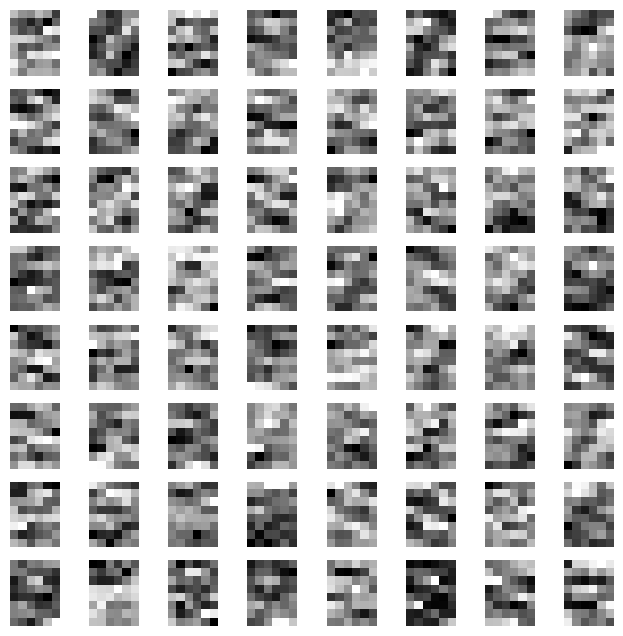

In [23]:
# Question 1-c) 
# Display the first layer of connection weights
def display_hidden_layer_features(We, Lin, Lhid):
    W1 = We[:Lin * Lhid].reshape(Lhid, Lin)
    plt.figure(figsize=(8, 8))
    for i in range(Lhid):
        plt.subplot(int(np.sqrt(Lhid)), int(np.sqrt(Lhid)), i + 1)
        plt.axis('off')
        plt.imshow(W1[i].reshape(8, 6), cmap='gray')
    plt.show()

display_hidden_layer_features(We_opt, params['Lin'], params['Lhid'])

Hidden layer size (Lhid): 16, Regularization parameter (lambda): 0


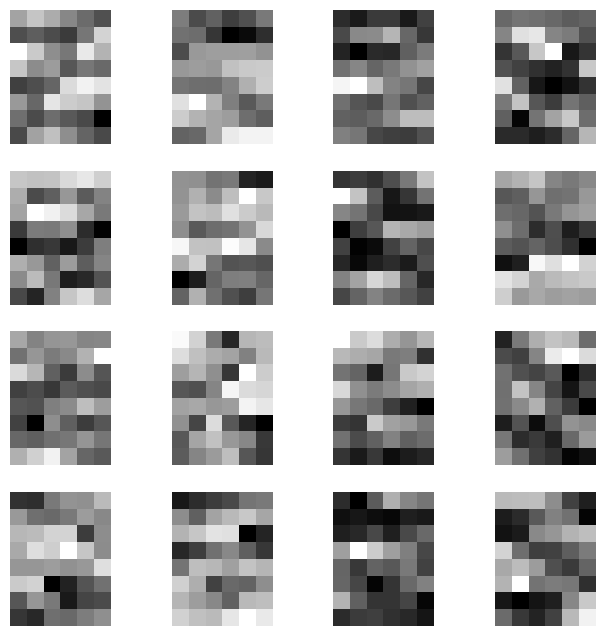

C:\Users\KEMAL\AppData\Local\Temp\ipykernel_13948\315519184.py:43: RuntimeWarning: divide by zero encountered in true_divide
  J_sparse = beta * np.sum(rho * np.log(rho / rho_hat) + (1 - rho) * np.log((1 - rho) / (1 - rho_hat)))
C:\Users\KEMAL\AppData\Local\Temp\ipykernel_13948\315519184.py:48: RuntimeWarning: divide by zero encountered in true_divide
  delta2 = (W2.T @ delta3 + beta * (-rho / rho_hat + (1 - rho) / (1 - rho_hat))) * a2 * (1 - a2)
C:\Users\KEMAL\AppData\Local\Temp\ipykernel_13948\315519184.py:48: RuntimeWarning: invalid value encountered in multiply
  delta2 = (W2.T @ delta3 + beta * (-rho / rho_hat + (1 - rho) / (1 - rho_hat))) * a2 * (1 - a2)


Hidden layer size (Lhid): 16, Regularization parameter (lambda): 0.0005


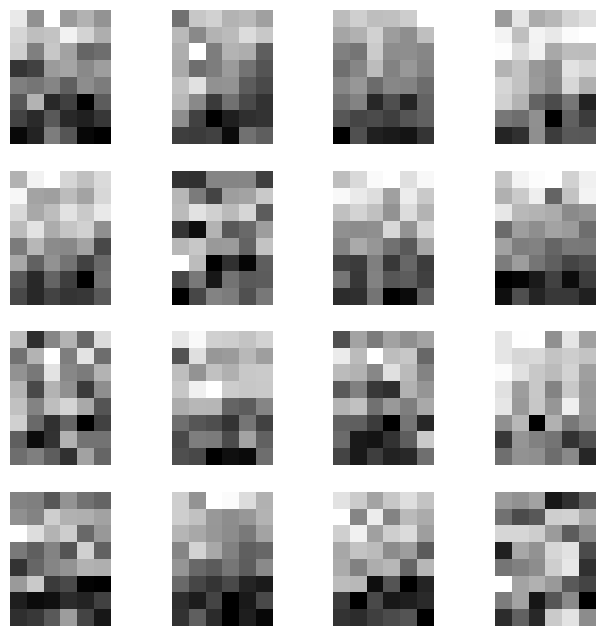

Hidden layer size (Lhid): 16, Regularization parameter (lambda): 0.001


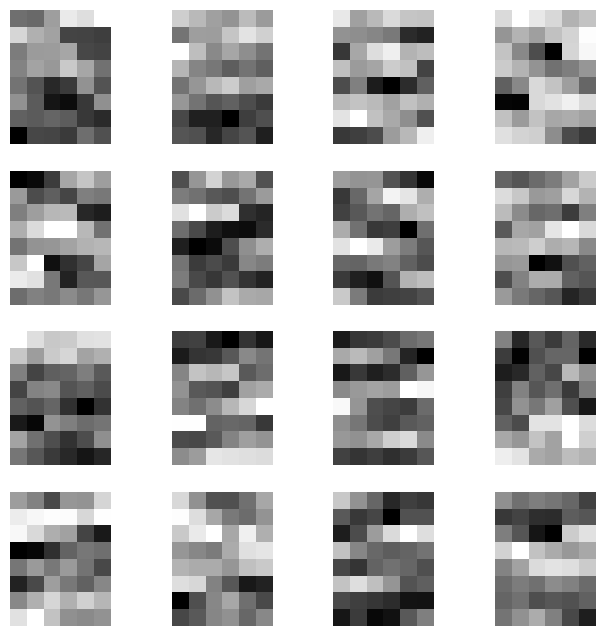

Hidden layer size (Lhid): 64, Regularization parameter (lambda): 0


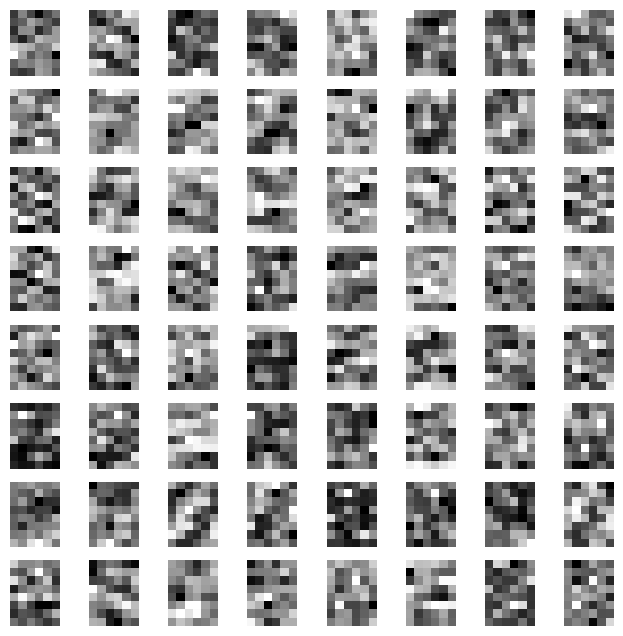

Hidden layer size (Lhid): 64, Regularization parameter (lambda): 0.0005


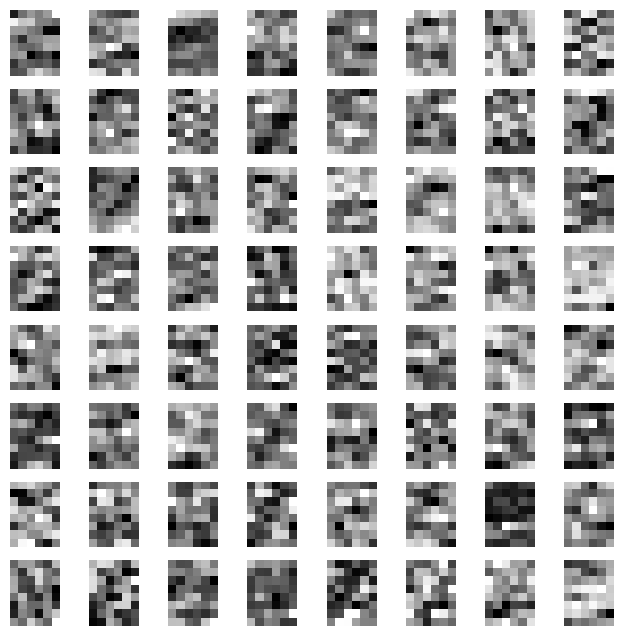

Hidden layer size (Lhid): 64, Regularization parameter (lambda): 0.001


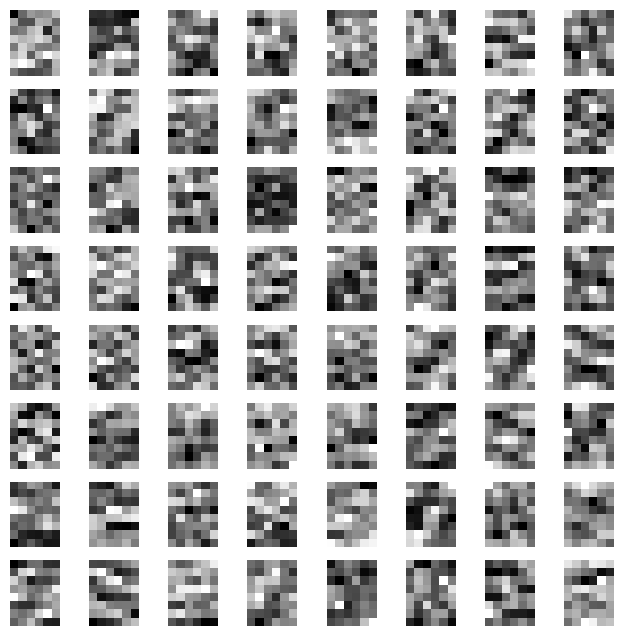

Hidden layer size (Lhid): 100, Regularization parameter (lambda): 0


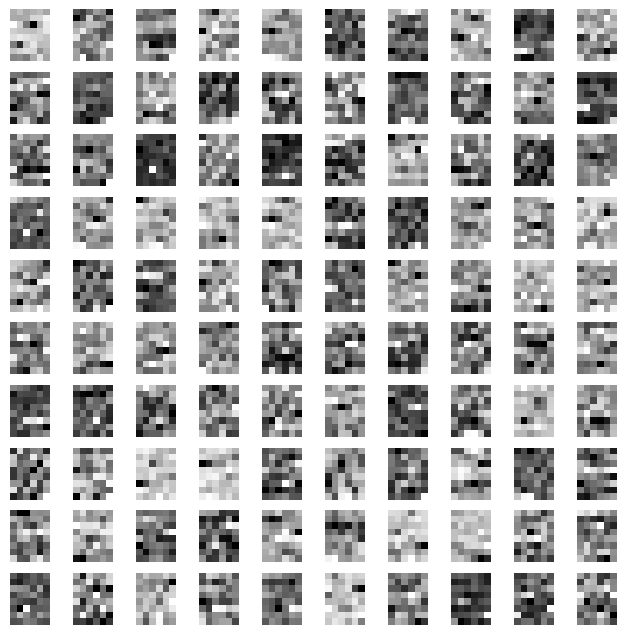

Hidden layer size (Lhid): 100, Regularization parameter (lambda): 0.0005


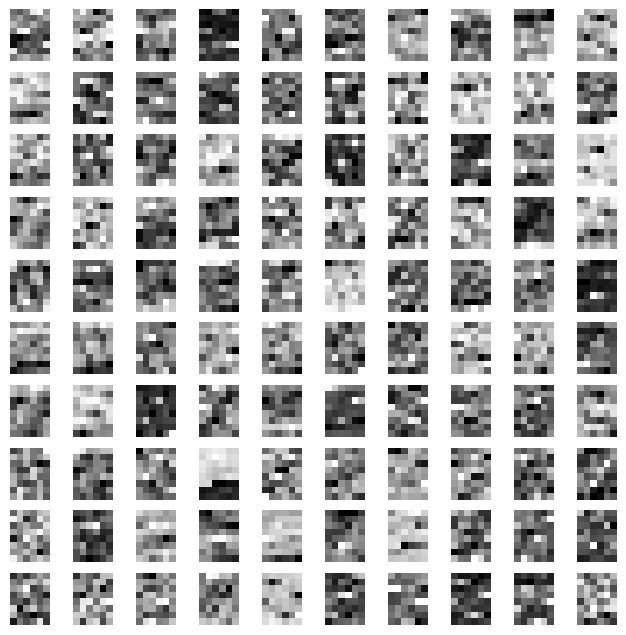

Hidden layer size (Lhid): 100, Regularization parameter (lambda): 0.001


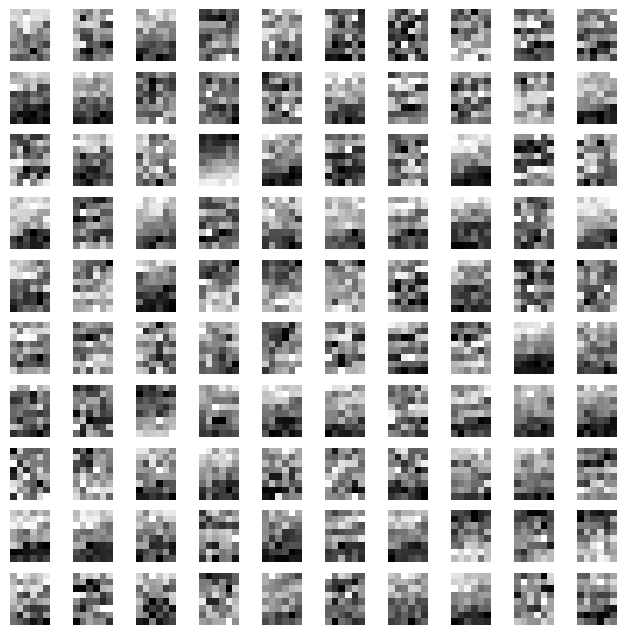

In [24]:
# Question 1-d) 
# Retrain the network for different Lhid and lambda values
Lhid_values = [16, 64, 100]
lambda_values = [0, 0.0005, 0.001]

for Lhid in Lhid_values:
    for lambda_ in lambda_values:
        params['Lhid'] = Lhid
        params['lambda'] = lambda_
        
        # Reinitialize weights and biases
        W1_init = np.random.randn(params['Lhid'], params['Lin']) * np.sqrt(2 / (params['Lin'] + params['Lhid']))
        W2_init = np.random.randn(params['Lout'], params['Lhid']) * np.sqrt(2 / (params['Lhid'] + params['Lout']))
        b1_init = np.zeros((params['Lhid'], 1))
        b2_init = np.zeros((params['Lout'], 1))

        # Flatten and concatenate all weights and biases
        We_init = np.concatenate([W1_init.flatten(), W2_init.flatten(), b1_init.flatten(), b2_init.flatten()])

        # Minimize cost function
        result = minimize(aeCost, We_init, args=(reshaped_data, params), jac=True, method='L-BFGS-B')

        # Extract optimized weights
        We_opt = result.x

        print(f"Hidden layer size (Lhid): {Lhid}, Regularization parameter (lambda): {lambda_}")
        display_hidden_layer_features(We_opt, params['Lin'], params['Lhid'])